In [1]:
import polars as pl
from matplotlib import pyplot as plt
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
from utils import adjacencyplot, cell_type_palette
import seaborn as sns

In [2]:
conn_df = pl.read_delta("../results/cellcellconnectivitylong/")
result = conn_df.filter(pl.col("measurement_type") == "SUM_ANATOMICAL_SIZE")

datasets = pl.read_delta("../results/dataset/")
datasets

id,name,publication,modality,project_id
str,str,str,str,str
"""minnie65_v1412_csm_cluster""","""Minnie65 v1412 CSM Dendrite Ul…","""none""","""ELECTRON_MICROSCOPY""","""minnie65"""
"""minnie65_v1412_proofread""","""Minnie65 v1412 Cells With Proo…","""none""","""ELECTRON_MICROSCOPY""","""minnie65"""


In [3]:
result.to_pandas()

,id,description,presynaptic_cell,postsynaptic_cell,modality,value,unit,project_id,measurement_type
0,43176584,None,337175,304043,None,5984.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE
1,43181492,None,330167,339142,None,5920.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE
2,43181499,None,273595,339142,None,3852.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE
3,43183398,None,301121,339142,None,11504.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE
4,43183978,None,273595,205051,None,6244.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE
...,...,...,...,...,...,...,...,...,...
796093,303199984,None,497103,422139,None,4872.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE
796094,303200956,None,463716,422139,None,2220.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE
796095,303201438,None,490761,422139,None,2904.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE
796096,303201480,None,363525,422139,None,5148.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE


In [4]:
data_items = pl.read_delta("../results/dataitem_dataset_association/")
prf_cells=data_items.filter(pl.col("dataset_id") == "minnie65_v1412_proofread")
feat_cells= data_items.filter(pl.col("dataset_id") == "minnie65_v1412_csm_cluster")

In [5]:
clusters=pl.read_delta("../results/cluster/")
cluster_members = pl.read_delta("../results/clustermembership/")
cell_types=cluster_members.join(clusters, left_on="cluster", right_on="id").filter(pl.col("level") == 2)


In [6]:
cell_types

item,cluster,membership_score,probability,distance,project_id,parent,children,level,score,hex_color,heirachy_category,distance_to_parent,project_id_right
str,str,f64,f64,f64,str,str,list[str],i64,f64,str,str,f64,str
"""204945""","""L6CT""",null,null,null,"""minnie65""","""glutamatergic""",null,2,null,"""#924455""","""subtype""",null,"""minnie65"""
"""524777""","""L4IT""",null,null,null,"""minnie65""","""glutamatergic""",null,2,null,"""#d29685""","""subtype""",null,"""minnie65"""
"""407636""","""L6CT""",null,null,null,"""minnie65""","""glutamatergic""",null,2,null,"""#924455""","""subtype""",null,"""minnie65"""
"""493863""","""L5IT""",null,null,null,"""minnie65""","""glutamatergic""",null,2,null,"""#b76969""","""subtype""",null,"""minnie65"""
"""565653""","""L6CT""",null,null,null,"""minnie65""","""glutamatergic""",null,2,null,"""#924455""","""subtype""",null,"""minnie65"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""269402""","""L5IT""",null,null,null,"""minnie65""","""glutamatergic""",null,2,null,"""#b76969""","""subtype""",null,"""minnie65"""
"""311962""","""L6CT""",null,null,null,"""minnie65""","""glutamatergic""",null,2,null,"""#924455""","""subtype""",null,"""minnie65"""
"""269817""","""L6IT""",null,null,null,"""minnie65""","""glutamatergic""",null,2,null,"""#7d354c""","""subtype""",null,"""minnie65"""


In [7]:
cell_features = pl.read_delta("../results/cellfeatures/csm_cluster_features")
nodes=cell_types.select(["item", "cluster", "parent"]).join(cell_features, left_on="item", right_on="id")

In [18]:
cell_feature_sets = pl.read_delta("../results/cellfeatureset/")
feature_set = cell_feature_sets.filter(pl.col("id") == "csm_cluster_features")
features = pl.read_delta("../results/cellfeaturedefinition/").filter(pl.col('id').is_in(feature_set['feature_definition_ids']))
features

id,description,unit,data_type,range_min,range_max
str,str,str,str,f64,f64
"""nucleus_volume_um""","""Nucleus volume""","""MICRONS_CUBED""","""<f4""",0.0,NaN
"""nucleus_area_um""","""Nucleus surface area""","""MICRONS_SQUARE""","""<f4""",0.0,NaN
"""nuclear_area_to_volume_ratio""","""Nucleus surface area to volume…","""MICRONS_INVERSE""","""<f4""",0.0,NaN
"""nuclear_folding_area_um""","""Area of nucleus in an infoldin…","""MICRONS_SQUARE""","""<f4""",0.0,NaN
"""fraction_nuclear_folding""","""Fraction of nucleus in an info…","""RATIO""","""<f4""",0.0,1.0
…,…,…,…,…,…
"""branch_svd3""","""SVD loading dendritic path len…","""RATIO""","""<f4""",NaN,NaN
"""branch_svd4""","""SVD loading dendritic path len…","""RATIO""","""<f4""",NaN,NaN
"""ego_count_pca0""","""PC loading synapse depth relat…","""RATIO""","""<f4""",NaN,NaN


In [ ]:
# df=result.to_pandas()
# node_df = nodes.to_pandas()
# df['log_syanpse_size'] = np.log(df.value)
# f, ax = plt.subplots(figsize=(8,24))
# adjacencyplot(df,
#               node_df,
#               node_id_col="item",
#               row_groupby=["parent", "cluster"],
#               col_groupby=["parent", "cluster"],
#               col_sortby=["median_density"],
#               node_palette=cell_type_palette,
#               pre_id_col="postsynaptic_cell",
#               post_id_col="presynaptic_cell",
#               arc_labels = None,
#               weight_col="log_syanpse_size",
#               plot_type="scattermap",
#               row_value_bars=["soma_volume_um","median_density"],
#               col_value_bars=["soma_volume_um","median_density"],
#               edge_hue=False,
#               hue_norm=(1,10),
#               sizes = (.1, 2),
#               size_norm=(0,13),
#               ax=ax)

In [ ]:
# f.savefig("../figures/celltype_connectivity_adjacency_plot.png")

In [19]:
clusters = pl.read_delta("../results/cluster/")
clusters


id,parent,children,level,score,hex_color,heirachy_category,distance_to_parent,project_id
str,str,list[str],i64,f64,str,str,f64,str
"""neuron""",null,"[""glutamatergic"", ""gabaergic""]",0,null,"""#000000""","""major_class""",null,"""minnie65"""
"""gabaergic""","""neuron""","[""PTC"", ""DTC"", … ""STC""]",1,null,"""#0000FF""","""class""",null,"""minnie65"""
"""glutamatergic""","""neuron""","[""L4IT"", ""L6CT"", … ""L6SP""]",1,null,"""#FF0000""","""class""",null,"""minnie65"""
"""PTC""","""gabaergic""",null,2,null,"""#364a7a""","""subtype""",null,"""minnie65"""
"""DTC""","""gabaergic""",null,2,null,"""#80c5c0""","""subtype""",null,"""minnie65"""
…,…,…,…,…,…,…,…,…
"""L5IT""","""glutamatergic""",null,2,null,"""#b76969""","""subtype""",null,"""minnie65"""
"""L6IT""","""glutamatergic""",null,2,null,"""#7d354c""","""subtype""",null,"""minnie65"""
"""L5ET""","""glutamatergic""",null,2,null,"""#c68076""","""subtype""",null,"""minnie65"""


In [20]:
umap = pl.read_delta("../results/cellfeatures/csm_cluster_features_umap").drop(['project_id','feature_set_id'])
cell_cluster = pl.read_delta("../results/clustermembership").select(['item', 'cluster'])
anatomy = pl.read_delta("../results/cellfeatures/minnie65_std_transform_coordinates").drop(['project_id','feature_set_id'])
nodes=cell_cluster.join(umap, left_on='item', right_on='id').join(anatomy, left_on='item', right_on='id')

pallete = {}
for row in clusters.select(['id', 'hex_color']).rows():
    pallete[row[0]]=row[1]

In [23]:
nodes

item,cluster,x_umap,y_umap,x_medial-lateral,y_dorsal-ventral,z_caudal-rostral
str,str,f32,f32,f32,f32,f32
"""373879""","""neuron""",7.508989,-1.197999,0.207047,-0.137865,0.019593
"""373879""","""glutamatergic""",7.508989,-1.197999,0.207047,-0.137865,0.019593
"""373879""","""L6CT""",7.508989,-1.197999,0.207047,-0.137865,0.019593
"""372421""","""neuron""",5.793554,-1.315263,0.207183,-0.152452,0.024009
"""372421""","""glutamatergic""",5.793554,-1.315263,0.207183,-0.152452,0.024009
…,…,…,…,…,…,…
"""232979""","""glutamatergic""",-1.46937,-3.141372,0.129751,-0.184555,0.024666
"""232979""","""L5ET""",-1.46937,-3.141372,0.129751,-0.184555,0.024666
"""267033""","""neuron""",-1.466739,-3.132531,0.155921,-0.175633,0.020768


<Axes: xlabel='x_umap', ylabel='y_umap'>

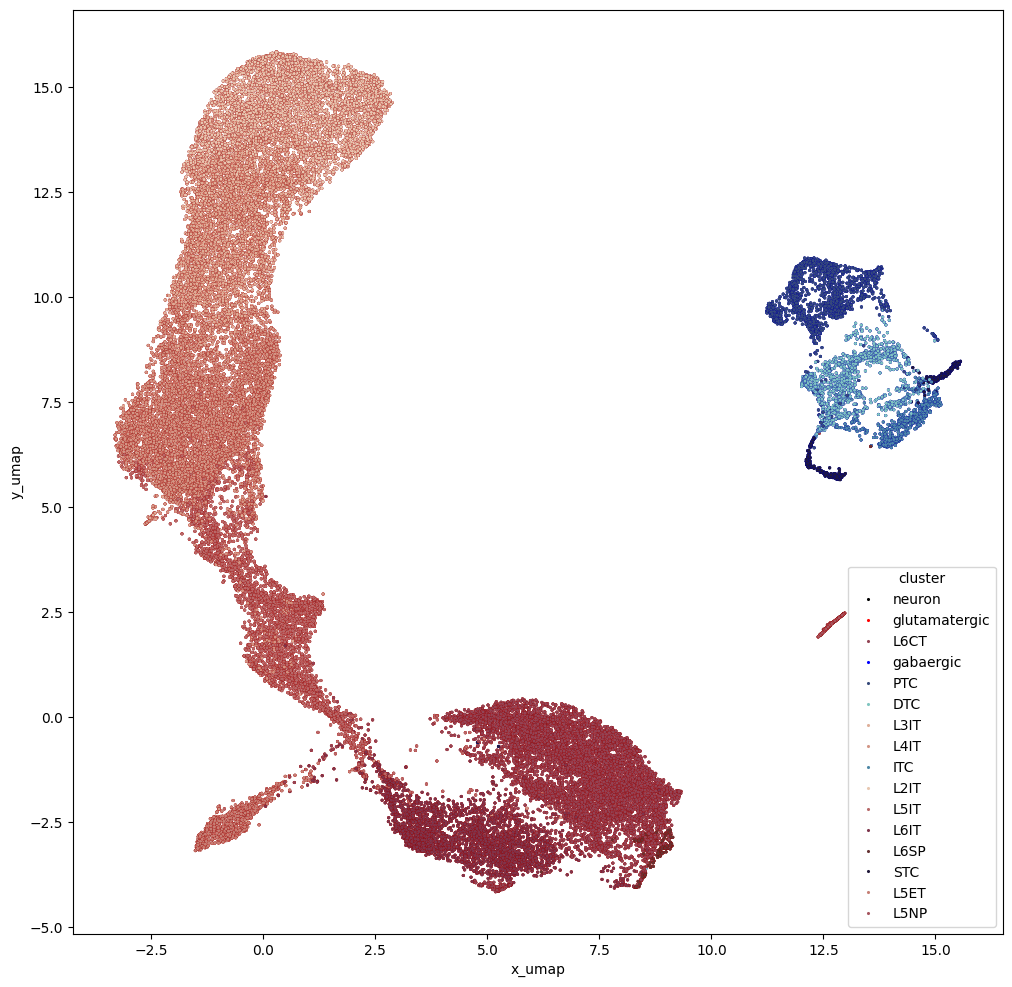

In [22]:
f, ax = plt.subplots(figsize=(12,12))

sns.scatterplot(data=nodes,
                x='x_umap',
                y='y_umap',
                hue='cluster',
                s=5,
                palette=pallete, 
                linewidths=0, ax=ax)

<Axes: xlabel='x_medial-lateral', ylabel='y_dorsal-ventral'>

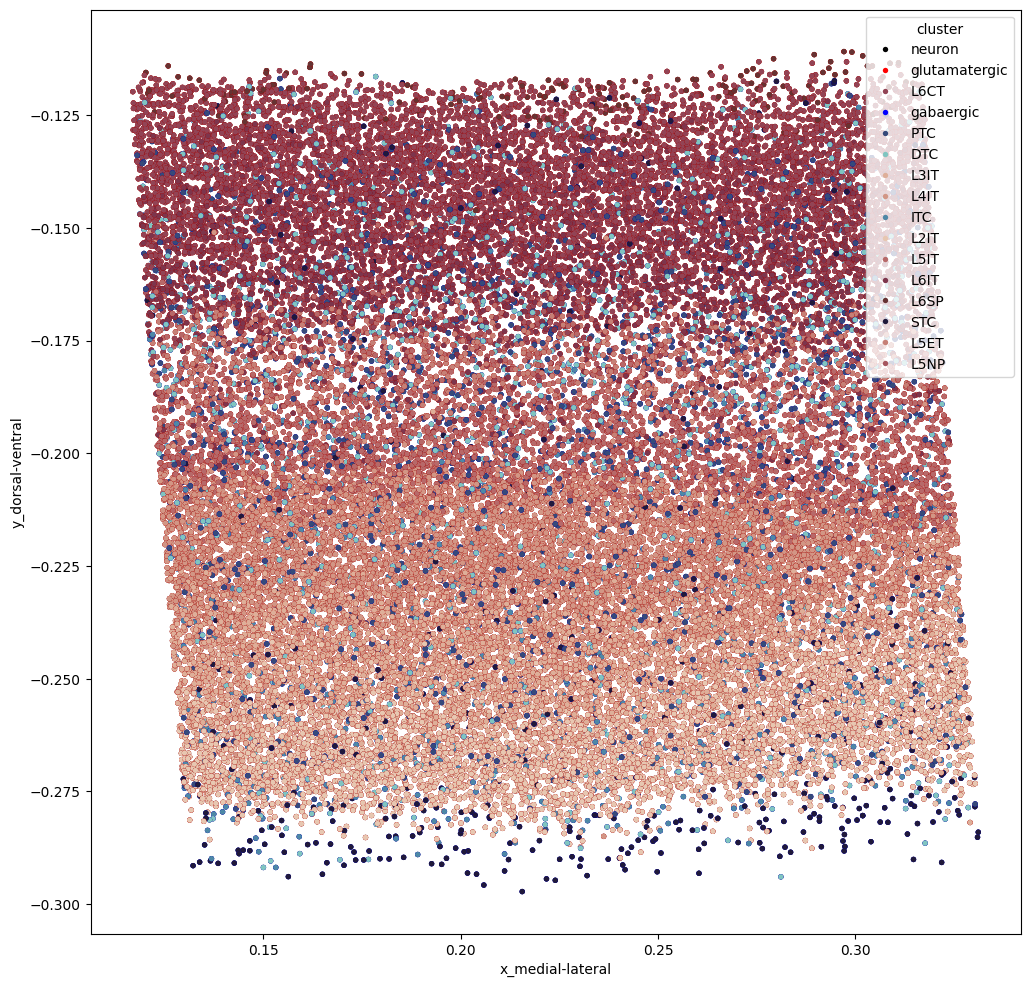

In [26]:
f, ax = plt.subplots(figsize=(12,12))

sns.scatterplot(data=nodes,
                x='x_medial-lateral',
                y='y_dorsal-ventral',
                hue='cluster',
                s=15,
                palette=pallete, 
                linewidths=0, ax=ax)
